# Score-matching informed KDE

In [7]:
!pip install memory_profiler
!pip install tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm
import function_cpu as LearnCholesky
import torch.multiprocessing as mp

from memory_profiler import profile
from tqdm import trange
import time
import gc
# git testing

In [8]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available")
print(device)

GPU is not available
cpu


### Parsing for scripts

In [9]:
parser = argparse.ArgumentParser(' ')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings','swissroll_6D_xy1', 'cifar10'], type = str,default = '2spirals')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 5)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 64)
parser.add_argument('--niters',type = int, default = 5000)
parser.add_argument('--batch_size', type = int,default = 4)
parser.add_argument('--lr',type = float, default = 2e-3) 
parser.add_argument('--save',type = str,default = 'experiments/')
parser.add_argument('--train_kernel_size',type = int, default = 100)
parser.add_argument('--train_samples_size',type = int, default = 500)
parser.add_argument('--test_samples_size',type = int, default = 5)
args = parser.parse_args('')

In [10]:
train_kernel_size = args.train_kernel_size
train_samples_size = args.train_samples_size
test_samples_size = args.test_samples_size
dataset = args.data 
save_directory = args.save + 'test'+'/'

print('save_directory',save_directory)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print('Created directory ' + save_directory)

save_directory experiments/test/


### Precision matrix model

In [11]:
## Cholesky factor model
def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)   

### Helper functions

In [12]:
@profile
def evaluate_model(factornet, kernel_centers, num_test_sample):
    '''
    Evaluate the model by computing the average total loss over 10 batch of testing samples
    '''
    total_loss_sum = 0
    device = kernel_centers.device
    for i in range(10):
        p_samples = toy_data.inf_train_gen(dataset,batch_size = num_test_sample)
        testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
        total_loss = LearnCholesky.score_implicit_matching(factornet,testing_samples,kernel_centers)
        total_loss_sum += total_loss.item()
         # Free up memory
        del p_samples, testing_samples, total_loss
        #gc.collect()
        torch.cuda.empty_cache()  # Only if using GPU
    average_total_loss = total_loss_sum / 10
    return average_total_loss

def save_training_slice_cov(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training slice of the density plot
    '''
    if means.shape[1] != 2:
        return
    plot_axis = means.max().item() * 1.1
    device = means.device
    # Create x as a NumPy array
    x_np = np.meshgrid(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200))
    x_np = np.stack(x_np, axis=-1).reshape(-1, 2)

    x = torch.tensor(x_np, dtype=torch.float32, device=device)
    data_dim = x.shape[1]
    precisions = LearnCholesky.vectors_to_precision(factornet(means),data_dim)
    density = LearnCholesky.mog_density(x, means, precisions)
    density = density.reshape(200, 200).T

    # Create a figure
    fig = plt.figure(figsize=(8, 4))
    plt.clf()
    
    plt.subplot(1, 2, 1) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    plt.axis('square')
    plt.colorbar()     
    
    plt.subplot(1, 2, 2) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    # Plot the centers
    num_components = torch.min(torch.tensor([means.shape[0], 400]))
    plot_centers = means[:num_components].detach().cpu().numpy()
    plt.scatter(plot_centers[:,1], plot_centers[:,0], s=0.2, c='r')
    plt.axis('square')
    # plt.colorbar()    
    plt.title(f'Epoch: {epoch}, Loss: {loss_value:.3e}')
             
    plt.tight_layout()  # Improve subplot spacing

    # Save the figure
    lr_str = f'{lr:.2e}'
    if save is not None:
        plt.savefig(f'{save}batch_size_{batch_size}lr_{lr_str}_epoch_{epoch}.png')

    plt.close(fig)

### Initialize score network

data_dim 2


array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>]],
      dtype=object)

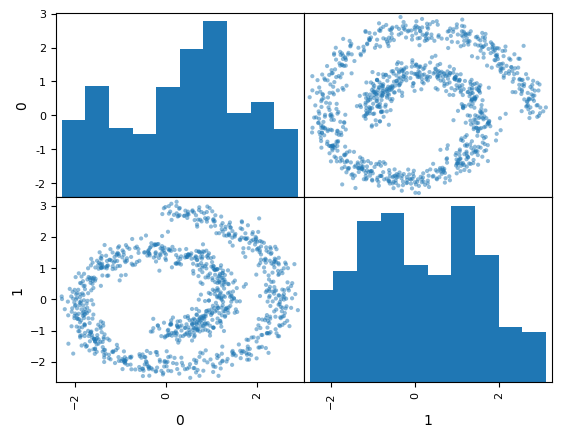

In [13]:
# check the dataset
dataset = args.data
dataset = 'swissroll'
# dataset = 'swissroll_6D_xy1'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)

## Initialize Data using CIFAR-10


In [14]:
# check the dataset
dataset = args.data
dataset = 'cifar10'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)
data_dim = means.shape[1]
# dataset = 'swissroll_6D_xy1'
""""" # not used anymore since our data is pictures
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""


tensor(-1.) tensor(1.)


/var/tmp/ipykernel_325981/310266888.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)


'"" # not used anymore since our data is pictures\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint(\'data_dim\',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n'

In [15]:
depth = args.depth
hidden_units = args.hiddenunits
factornet = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)

lr = args.lr
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

p_samples = toy_data.inf_train_gen(dataset,batch_size = train_samples_size)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)

# torch.save(centers, save_directory + 'centers.pt')

epochs = args.niters
batch_size = args.batch_size

# Training the score network
#loss = evaluate_model(factornet, centers, test_samples_size)
#formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
#print(f'Before train, Average total_loss: {formatted_loss}')

tensor(-1.) tensor(1.)


/var/tmp/ipykernel_325981/3990223035.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)


/var/tmp/ipykernel_325981/3990223035.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


In [16]:
@profile
def opt_check(factornet, samples, centers):
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Use trange instead of range to get tqdm progress bar
for step in trange(epochs, desc="Training"):
    print(f"Step {step} started")
    randind = torch.randint(0, train_samples_size, [batch_size,])
    samples = training_samples[randind, :]
    loss_value = opt_check(factornet, samples, centers)

    if step % 4000 == 0:
        print(f'Step: {step}, Loss value: {loss_value:.3e}')
    """
    if step % 20000 == 0:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
    """
    
    if step < epochs - 1:
        del samples
        gc.collect()
        torch.cuda.empty_cache()


Training:   0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 0 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   3818.8 MiB   3818.8 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

/home/jupyter/wpo_distill/function_cpu.py:258: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast('cpu', dtype=torch.bfloat16):
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   188  11144.2 MiB  11144.2 MiB           1   @profile
   189                                         def laplacian_mog_density_div_density(x, means, precisions):
   190  11144.2 MiB      0.0 MiB           1       x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
   191  11144.2 MiB      0.0 MiB           1       batch_size, num_components = x.size(0), means.size(0)
   192                                         
   193                                             # Create a batch of Multivariate Normal distributions for each component
   194  21946.8 MiB  10802.6 MiB           1       mvns = MultivariateNormal(loc=means, precision_matrix=precisions)
   195                                         
   196                                             # Calculate the log probabilities for each component
   197  21961.8 MiB     15.0 MiB           1       log_probs = mvns.log_prob

Training:   0%|          | 1/5000 [02:08<178:15:37, 128.37s/it]

Step: 0, Loss value: 5.753e+04
Step 1 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   7600.9 MiB   7600.9 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                     

Training:   0%|          | 2/5000 [03:39<147:52:30, 106.51s/it]

Step 2 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   7825.3 MiB   7825.3 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 3/5000 [05:09<137:21:08, 98.95s/it] 

Step 3 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   7920.1 MiB   7920.1 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 4/5000 [06:40<132:49:18, 95.71s/it]

Step 4 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   8078.8 MiB   8078.8 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 5/5000 [08:10<129:56:38, 93.65s/it]

Step 5 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   8190.4 MiB   8190.4 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 6/5000 [09:40<128:30:33, 92.64s/it]

Step 6 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   8319.3 MiB   8319.3 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 7/5000 [11:10<127:10:35, 91.70s/it]

Step 7 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   8406.5 MiB   8406.5 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 8/5000 [12:40<126:31:35, 91.25s/it]

Step 8 started
ERROR: Could not find file /var/tmp/ipykernel_325981/1704203405.py
Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   8482.0 MiB   8482.0 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                

Training:   0%|          | 8/5000 [14:10<147:20:35, 106.26s/it]


KeyboardInterrupt: 

In [10]:

import time

for step in range(epochs):
    start = time.time()
    # samples_toydata
    randind = torch.randint(0,train_samples_size,[batch_size,])
    samples = training_samples[randind,:]
    loss_value = opt_check(factornet, samples, centers)
    """
    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    """
   
    
    if not step % 4000:
        #loss_value = loss.item()
        print(f'Step: {step}, Loss value: {loss_value:.3e}')

    if not step % 20000:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)
    if step < epochs - 1:
         # Free up memory
        del samples # del loss
        gc.collect()
        torch.cuda.empty_cache()
    print("Elapsed time:", time.time() - start)
    
    
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

ERROR: Could not find file /var/tmp/ipykernel_174720/1267574142.py


/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   3825.4 MiB   3825.4 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                                             Returns:
    26                                      

/home/jupyter/wpo_distill/function_cpu.py:258: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast('cpu', dtype=torch.bfloat16):
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   188  11152.4 MiB  11152.4 MiB           1   @profile
   189                                         def laplacian_mog_density_div_density(x, means, precisions):
   190  11152.4 MiB      0.0 MiB           1       x = x.unsqueeze(1)  # Shape: (batch_size, 1, 2)
   191  11152.4 MiB      0.0 MiB           1       batch_size, num_components = x.size(0), means.size(0)
   192                                         
   193                                             # Create a batch of Multivariate Normal distributions for each component
   194  21955.3 MiB  10802.9 MiB           1       mvns = MultivariateNormal(loc=means, precision_matrix=precisions)
   195                                         
   196                                             # Calculate the log probabilities for each component
   197  21969.8 MiB     14.5 MiB           1       log_probs = mvns.log_prob

/var/tmp/ipykernel_174720/4110140829.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


Filename: /home/jupyter/wpo_distill/function_cpu.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    16   7563.0 MiB   7563.0 MiB           1   @profile
    17                                         def vectors_to_precision(vectors,dim):
    18                                             """
    19                                             Maps an array of 1xdim vectors into Cholesky factors and returns an array of precision matrices.
    20                                             
    21                                             Args:
    22                                             vectors (torch.Tensor): A tensor of shape (batch_size, 1, dim), where each 1xdim tensor represents the
    23                                                                     lower triangular part of the Cholesky factor.
    24                                             
    25                                             Returns:
    26                                      

KeyboardInterrupt: 

In [ ]:
# sample from trained model
# and plot density
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)
LearnCholesky.plot_images(centers, precisions,plot_number=10,save_path=save_directory + 'samples.png')

""" I think this will not work for general (centers needs to be same as before to plot properly)
randind = torch.randint(0,1000,[1000,])
centers = means[randind,:].to(device)
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)

LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')
LearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')
"""

In [ ]:
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 2, dim2 = 3, save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 2, dim2 = 3, save_path=save_directory + 'density.png')
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 4, dim2 = 5,  save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 4, dim2 = 5,save_path=save_directory + 'density.png')